In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [17]:
datatrain = pd.read_csv(r'D:\GitHubProject\SRTP-program-of-SEU---meteorological-forecasting\mintempe\Train.csv',engine = 'python')
datatest = pd.read_csv(r'D:\GitHubProject\SRTP-program-of-SEU---meteorological-forecasting\mintempe\Test.csv',engine = 'python')

traindataset = datatrain['DailyMinimumDryBulbTemperature'].values
testdataset = datatest['DailyMinimumDryBulbTemperature'].values
# 转为len*1列的数组
traindataset = traindataset.reshape(-1,1)
traindataset = traindataset.astype('float32')
testdataset = testdataset.reshape(-1,1)
testdataset = testdataset.astype('float32')

C:\Users\PC\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\PC\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\PC\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


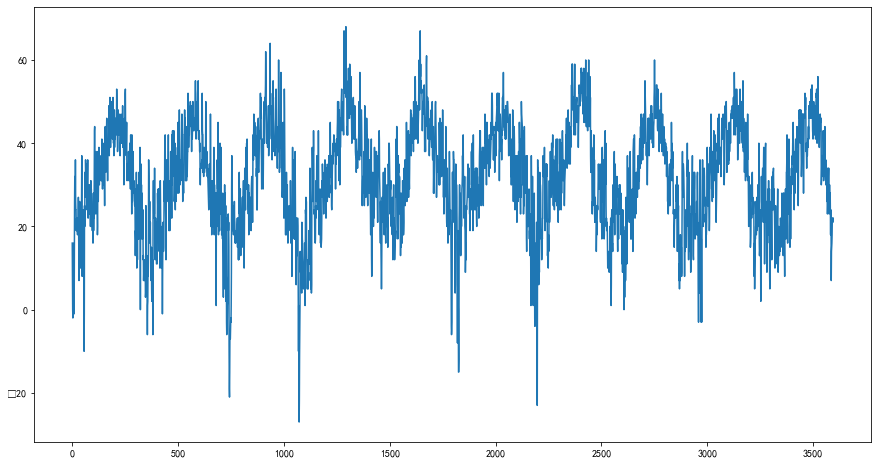

In [18]:
# 绘制原始数据曲线
dataset = np.vstack((traindataset,testdataset));
plt.figure(figsize = (15,8))
plt.plot(dataset)

In [19]:
traindataset.shape, testdataset.shape

((2876, 1), (720, 1))

In [20]:
# 数据预处理
# dateset为数据，look_back为以几行数据为特征数目
# 即预测第 i 天数据时，以第 i-look_back 到 i-1天的数据作为参考
def creat_dataset(ds, look_back=1):
    dataX, dataY = [], []
    for i in range(len(ds)-look_back):
        a = ds[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(ds[i+look_back,0])
    return np.array(dataX),np.array(dataY)

In [21]:
# 将数据归 1 化
scaler  = MinMaxScaler(feature_range = (0, 1))
scaler.fit(dataset)
traindataset = scaler.transform(traindataset)
testdataset = scaler.transform(testdataset)
dataset = scaler.transform(dataset)

train = traindataset.copy()
test = testdataset.copy()

look_back = 3
trainX, trainY = creat_dataset(train,look_back)
testX, testY = creat_dataset(test,look_back)
trainX.shape,testX.shape

((2873, 3), (717, 3))

In [22]:
# LSTM要求输入是3维的
# 第二维是 timesteps，第三维是 features
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))
trainX.shape,testX.shape

((2873, 1, 3), (717, 1, 3))

In [23]:
trainY.shape,testY.shape

((2873,), (717,))

In [24]:
# 创建 LSTM Model
# 可以在 youtube 搜 keras+lstm，或者看 Jason Brownlee 的博客详细了解
model = Sequential()
# input_shape 两个参数对应 timesteps 和 features 数
model.add(LSTM(4,input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
# 实测训练 10 次取得较好的预测结果
model.fit(trainX,trainY,epochs=100,batch_size=4,verbose=2)
# 对训练集和测试集分别进行预测
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
 - 12s - loss: 0.0415
Epoch 2/100
 - 8s - loss: 0.0058
Epoch 3/100
 - 9s - loss: 0.0054
Epoch 4/100
 - 5s - loss: 0.0051
Epoch 5/100
 - 5s - loss: 0.0049
Epoch 6/100
 - 8s - loss: 0.0047
Epoch 7/100
 - 10s - loss: 0.0046
Epoch 8/100
 - 8s - loss: 0.0045
Epoch 9/100
 - 9s - loss: 0.0045
Epoch 10/100
 - 10s - loss: 0.0044
Epoch 11/100
 - 7s - loss: 0.0044
Epoch 12/100
 - 7s - loss: 0.0044
Epoch 13/100
 - 7s - loss: 0.0044
Epoch 14/100
 - 9s - loss: 0.0044
Epoch 15/100
 - 6s - loss: 0.0044
Epoch 16/100
 - 11s - loss: 0.0044
Epoch 17/100
 - 4s - loss: 0.0044
Epoch 18/100
 - 6s - loss: 0.0044
Epoch 19/100
 - 5s - loss: 0.0044
Epoch 20/100
 - 4s - loss: 0.0044
Epoch 21/100
 - 5s - loss: 0.0044
Epoch 22/100
 - 9s - loss: 0.0044
Epoch 23/100
 - 9s - loss: 0.0044
Epoch 24/100
 - 7s - loss: 0.0044
Epoch 25/100
 - 8s - loss: 0.0044
Epoch 26/100
 - 8s - loss: 0.0044
Epoch 27/100
 - 7s - loss: 0.0044
Epoch 28/100
 - 6s - loss: 0.0044
Epoch 29/100
 - 8s - loss: 0.0044
Epoch 30/100
 - 8s 

In [25]:
# 逆变换得真实值
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(np.array(trainY.reshape(-1,1)))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(np.array(testY.reshape(-1,1)))
dataset = scaler.inverse_transform(np.array(dataset.reshape(-1,1)))
test = scaler.inverse_transform(np.array(test.reshape(-1,1)))
train = scaler.inverse_transform(np.array(train.reshape(-1,1)))

# 误差分析
trainScore = mean_squared_error(trainY,trainPredict)
print('Train Score: %.2f MSE' % trainScore)
testScore = mean_squared_error(testY,testPredict)
print('Test Score: %.2f MSE' % testScore)

Train Score: 38.41 MSE
Test Score: 34.21 MSE


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [27]:
#plot_model(model,show_shapes=True)

C:\Users\PC\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\PC\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\PC\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


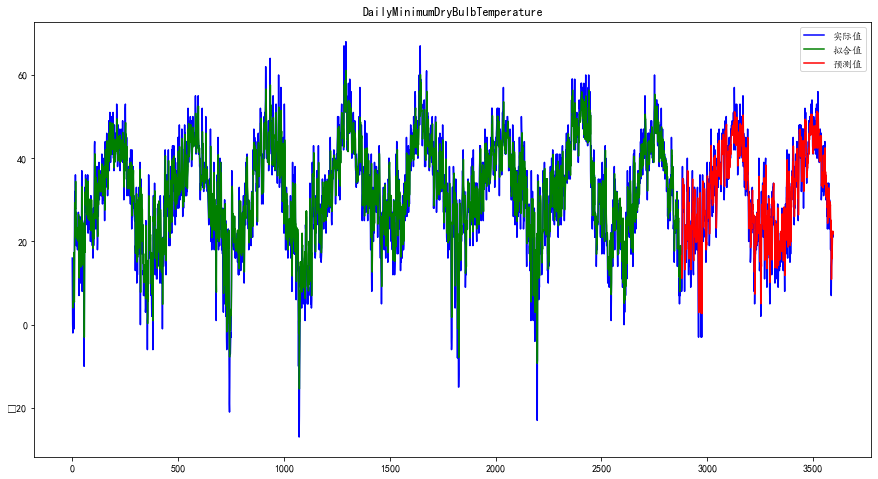

In [28]:
# 拷贝数据，注意每组数据前 look_back 天作为输入，无法预测，值设为 nan
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train)] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(train)+look_back:] = testPredict

# 绘图
plt.rcParams['font.sans-serif'] = 'KaiTi'
plt.figure(figsize=(15,8))
plt.title('DailyMinimumDryBulbTemperature')
plt.plot(dataset,color ='blue',label='实际值')
plt.plot(trainPredictPlot,color ='green',label='拟合值')
plt.plot(testPredictPlot,color ='red',label='预测值')
plt.legend(loc='best')

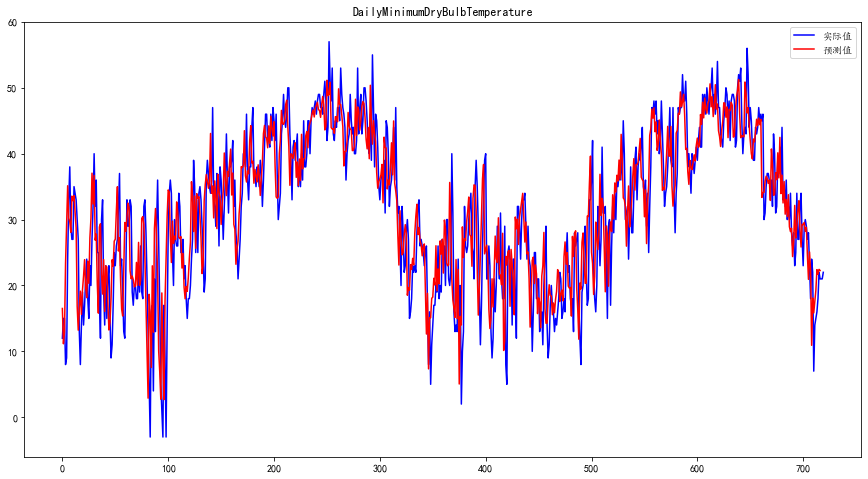

In [29]:
plt.rcParams['font.sans-serif'] = 'KaiTi'
plt.figure(figsize=(15,8))
plt.title('DailyMinimumDryBulbTemperature')
plt.plot(test,color ='blue',label='实际值')
plt.plot(testPredict,color ='red',label='预测值')
plt.legend(loc='best')

In [30]:
trainPredictPlot[len(train)+look_back:] = testPredict
pd.DataFrame(trainPredictPlot).to_csv('D:\\GitHubProject\\SRTP-program-of-SEU---meteorological-forecasting\\mintempe\\result_LSTM.csv',index = False)